<font color = red><b> To do list </b> </font>
<br>
[ ] Decision tree

Import Packages<br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print ("Leo_test")

Leo_test


Parameter setting
1. Folder path
2. Metadat

In [2]:
root_folder = 'HM1/'
train_file = 'train.csv'
test_file = 'test.csv'
Index = 'TransactionID'
Target = 'isFraud'

Read data

In [3]:
train = pd.read_csv(root_folder + train_file)
test = pd.read_csv(root_folder + test_file)
#print (train.columns)
train.shape

(472432, 27)

Basic statistics

C:\Users\behno\AppData\Local\Temp\ipykernel_4236\2767252254.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax  = plt.subplots(figsize= (5,3))


['C1' 'C10' 'C11' 'C12' 'C13' 'C14' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8'
 'C9' 'TransactionAmt' 'TransactionDT' 'isFraud']
['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'Num_Cat']


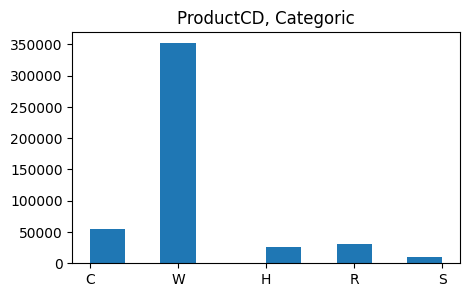

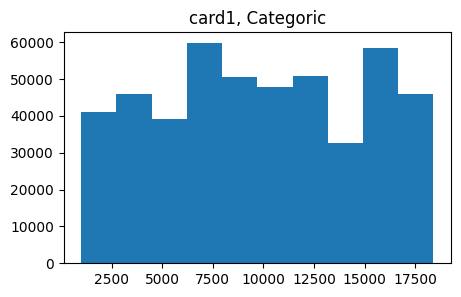

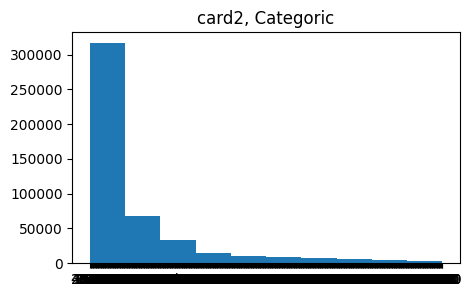

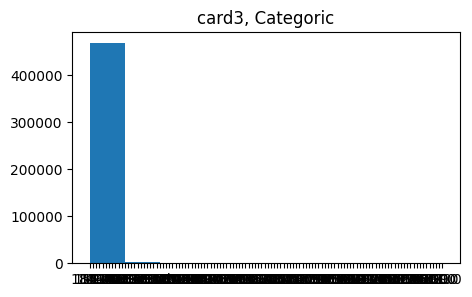

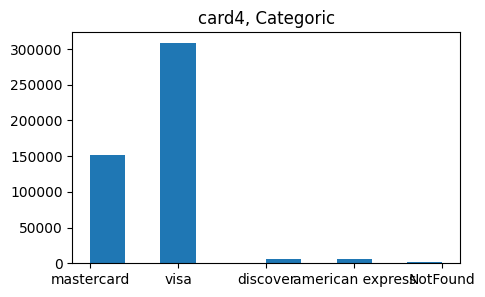

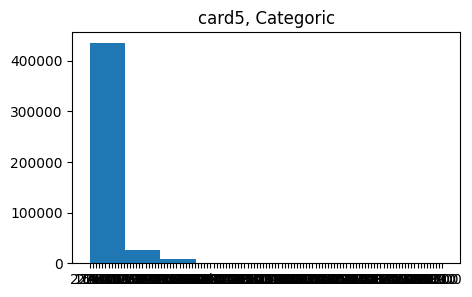

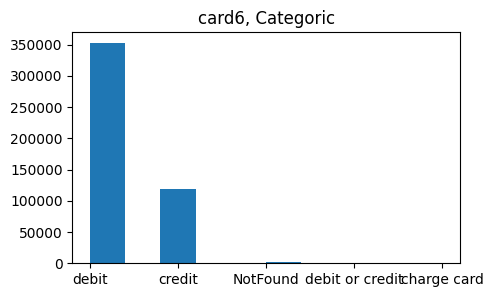

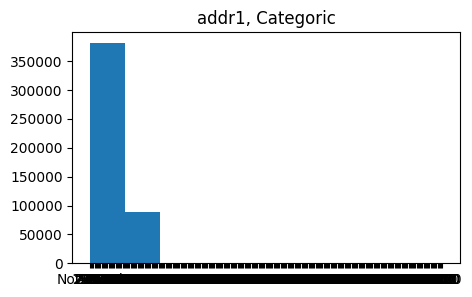

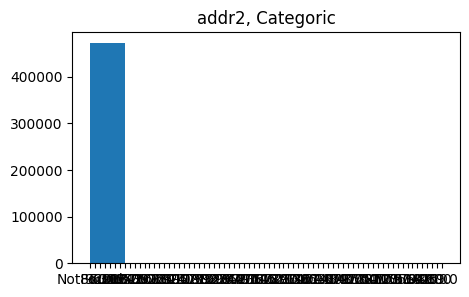

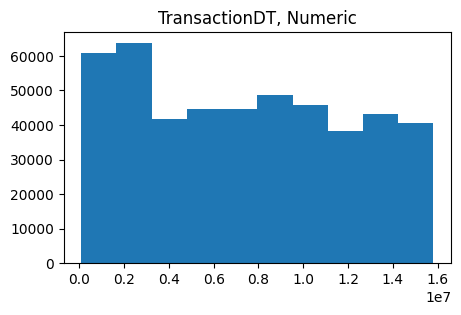

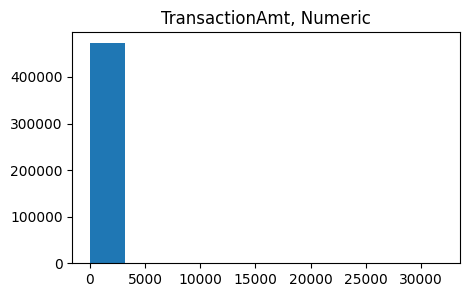

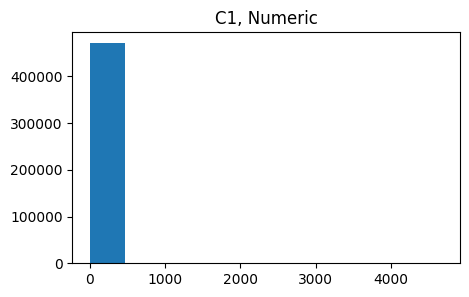

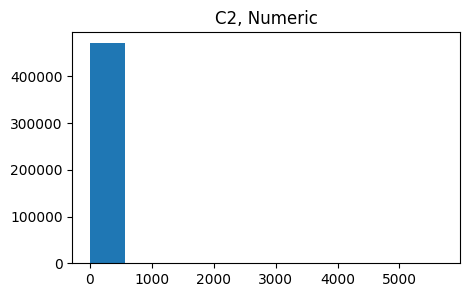

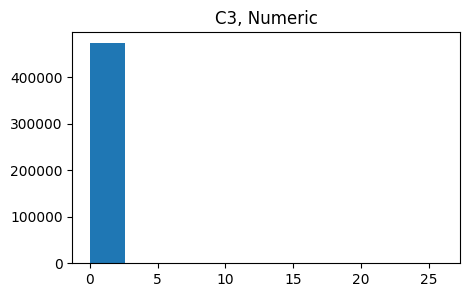

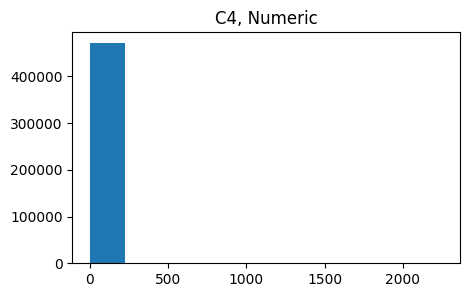

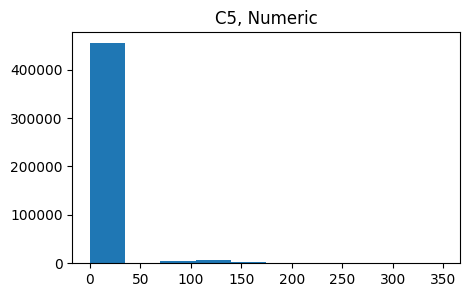

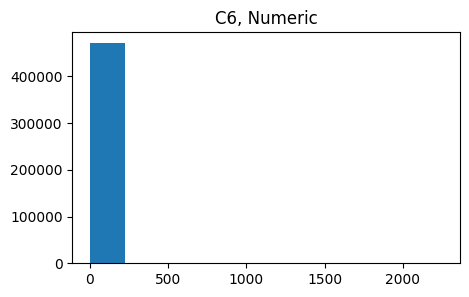

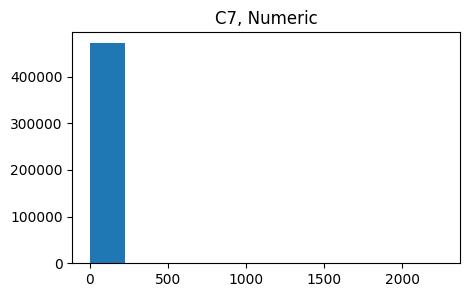

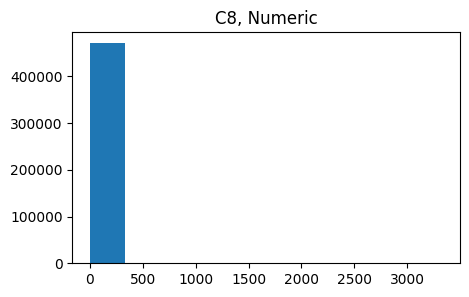

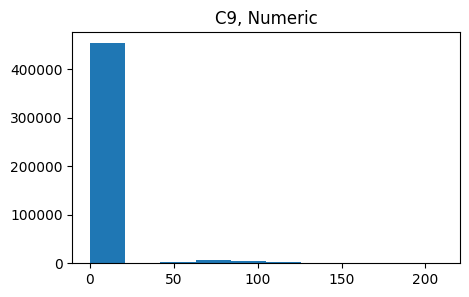

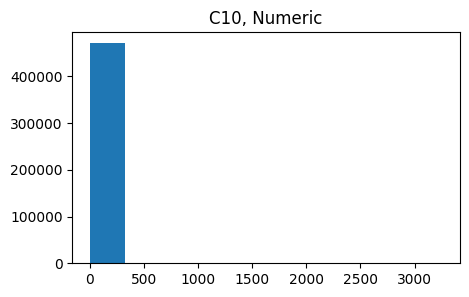

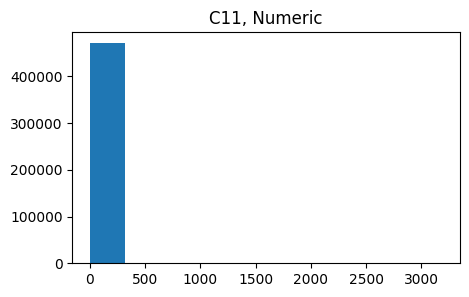

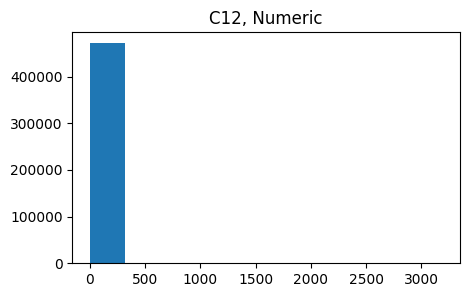

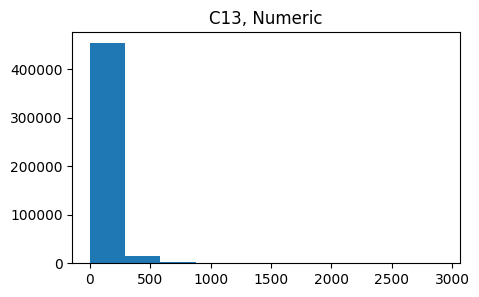

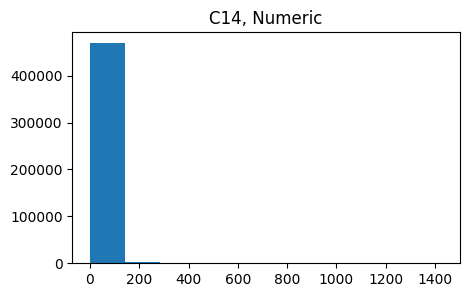

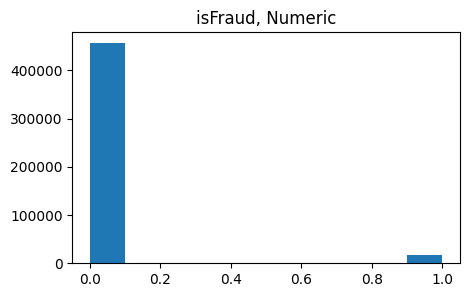

In [4]:
size = train.shape
Columns = train.columns.values
Columns = Columns[Columns != Index]
Categoric_features = ['ProductCD','card1','card2','card3','card4','card5','card6','addr1','addr2']
Numeric_features = np.setdiff1d(Columns, Categoric_features)
for i in Columns:
  fig, ax  = plt.subplots(figsize= (5,3))
  plt.hist(train[i])
  if i in Numeric_features:
    identify = 'Numeric'
  else:
    identify = 'Categoric'
  plt.title(f"{i:}, {identify}")
Categoric_features.append('Num_Cat')
print (Numeric_features)
print (Categoric_features)

Information gain function

In [26]:
train.head()
tmp = train.sort_values(by = 'card1')
tmp.head()

,TransactionID,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,C6,C7,C8,C9,C10,C11,C12,C13,C14,isFraud
19678,19679,W,1004,583.0,150.0,visa,226.0,credit,325.0,87.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
45755,45756,H,1011,543.0,150.0,mastercard,224.0,debit,337.0,87.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
14432,14433,W,1013,555.0,150.0,visa,226.0,debit,203.0,87.0,...,149.0,0.0,0.0,134.0,0.0,132.0,0.0,542.0,168.0,0.0
22191,22192,W,1013,555.0,150.0,visa,226.0,debit,203.0,87.0,...,151.0,0.0,0.0,134.0,0.0,133.0,0.0,543.0,169.0,0.0
18297,18298,W,1013,555.0,150.0,visa,226.0,debit,203.0,87.0,...,209.0,0.0,0.0,194.0,0.0,217.0,0.0,523.0,218.0,0.0


In [7]:
def IG(Input_Dataframe, Split_feature, IG_methods): #IG_methods = 'Gini'/ 'Entropy' / 'MisEr'
  length = Input_Dataframe.shape[0]
  Fraud_arr = Input_Dataframe[Target]
  #print ('Pass line 3')
  # propability of Fraud and not Fraud
  P_isF = float(len(Fraud_arr[Fraud_arr == 1])/length)
  #print (P_isF)
  P_notF = 1-P_isF
  Gini_root = 1 - np.power(P_isF,2)  - np.power(P_notF,2)
  Gini_leaves = [] #Gini index of each leaves
  Prop_leaves = [] #Propotion of each leaves
  IG_feature_Num = [] #IGs for numeric features
  #print ('Pass line 10')
  if Split_feature in Categoric_features:
    Feature_classes = np.unique(Input_Dataframe[Split_feature])
    if IG_methods == 'Gini':
      #print ('Pass line 15')
      for i in Feature_classes:
        Sub_df = Input_Dataframe[Input_Dataframe[Split_feature] == i]
        Sub_len = len(Sub_df)
        Sub_P_isF = len(Sub_df[Sub_df[Target] == 1])/Sub_len
        Sub_P_notF = 1-Sub_P_isF
        Gini_leaves.append(1 - np.power(Sub_P_isF,2)  - np.power(Sub_P_notF,2))
        Prop_leaves.append(Sub_len/length)
  elif Split_feature in Numeric_features:
    Sort_Input = np.unique(Input_Dataframe[Split_feature])
    Sort_Input = Sort_Input.astype(np.float64)
    #print (Sort_Input)
    tmp_Input_Dataframe = Input_Dataframe.copy()
    for i in Sort_Input:
      #print (i)
      tmp_Input_Dataframe.loc[tmp_Input_Dataframe[Split_feature] <= i,'Num_Cat'] = 0
      tmp_Input_Dataframe.loc[tmp_Input_Dataframe[Split_feature] > i,'Num_Cat'] = 1
      IG_feature_Num.append(IG(tmp_Input_Dataframe,'Num_Cat', IG_methods))
    IG_feature = max(IG_feature_Num)
    return [IG_feature, Sort_Input[IG_feature_Num.index(IG_feature)]]

  Gini_root = np.array(Gini_root)
  Prop_leaves = np.array(Prop_leaves)
  IG_feature = Gini_root - np.matmul(Gini_leaves,Prop_leaves.T)

  return IG_feature

In [ ]:
test1 = test.copy()
test1.loc[test1['C1'] <= 3, 'Num_Cat'] = 0
test1

In [8]:
test = train[30:40]
print(IG(test,'C1','Gini'))
test

[0.07999999999999993, 3.0]


,TransactionID,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,C6,C7,C8,C9,C10,C11,C12,C13,C14,isFraud
30,31,W,12501,490.0,150.0,visa,226.0,debit,181.0,87.0,...,3.0,0.0,0.0,1.0,0.0,2.0,0.0,5.0,1.0,0
31,32,C,5812,408.0,185.0,mastercard,224.0,debit,NotFound,NotFound,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0
32,33,W,12581,453.0,150.0,visa,226.0,debit,325.0,87.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,1.0,0
33,34,R,15066,170.0,150.0,mastercard,102.0,credit,299.0,87.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0
34,35,C,4301,273.0,185.0,mastercard,102.0,credit,NotFound,NotFound,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0
35,36,W,9500,321.0,150.0,visa,226.0,debit,433.0,87.0,...,9.0,0.0,0.0,8.0,0.0,8.0,0.0,105.0,8.0,0
36,37,W,5554,229.0,150.0,visa,226.0,credit,315.0,87.0,...,3.0,0.0,0.0,3.0,0.0,3.0,0.0,6.0,3.0,0
37,38,C,16136,204.0,185.0,visa,138.0,debit,NotFound,NotFound,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1
38,39,W,3368,572.0,150.0,mastercard,224.0,debit,251.0,87.0,...,2.0,0.0,0.0,2.0,0.0,2.0,0.0,10.0,2.0,0
39,40,W,18036,486.0,143.0,mastercard,224.0,debit,205.0,87.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0


<font color = red> **Experiment1: </font>** with only 100 random rows

Load data

In [ ]:
# shuffle the train data
train = train.sample(frac = 1)
Exp1_train = train[0:100]
Exp1_train.tail()

,TransactionID,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,C6,C7,C8,C9,C10,C11,C12,C13,C14,isFraud
3475,3476,W,15497,490.0,150.0,visa,226.0,debit,220.0,87.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0
3096,3097,W,17188,321.0,150.0,visa,226.0,debit,310.0,87.0,...,5.0,0.0,0.0,4.0,0.0,5.0,0.0,29.0,7.0,0
41412,41413,W,12389,532.0,150.0,mastercard,137.0,credit,485.0,87.0,...,17.0,0.0,0.0,12.0,0.0,11.0,0.0,77.0,18.0,0
252732,252733,W,1214,174.0,150.0,visa,226.0,credit,181.0,87.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,3.0,1.0,0
429720,429721,C,11436,555.0,150.0,visa,226.0,credit,NotFound,NotFound,...,16.0,16.0,33.0,0.0,17.0,20.0,20.0,2.0,2.0,1


Gini index for the Root node

In [ ]:
for i in Columns:
  if i in Categoric_features:

  if i in Numeric_features:




array(['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'TransactionDT', 'TransactionAmt', 'C1', 'C2',
       'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12',
       'C13', 'C14', 'isFraud'], dtype=object)

<font color = 'green'><b> -------- Leo end --------- </b></font>

<font color = 'Blue'><b> -------- Behnoud start -------- </b></font>

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')
train=pd.read_csv('sample_data/train.csv')
test=pd.read_csv('sample_data/test.csv')
train

FileNotFoundError: [Errno 2] No such file or directory: 'sample_data/train.csv'

In [ ]:
def IG_Numeric(Input_Dataframe, Split_feature, IG_methods): #IG_methods = 'Gini'/ 'Entropy' / 'MisEr'
  length = Input_Dataframe.shape[0]
  Fraud_arr = Input_Dataframe[Target]
  print ('Pass line 3')
  # propability of Fraud and not Fraud
  P_isF = len(Fraud_arr[Fraud_arr == 1])/length
  P_notF = 1-P_isF
  Gini_root = 1 - np.power(P_isF,2)  - np.power(P_notF,2)
  Gini_leaves = [] #Gini index of each leaves
  Prop_leaves = [] #Propotion of each leaves
  print ('Pass line 10')
  if Split_feature in Numeric_features:
    Feature_classes = np.unique(Input_Dataframe[Split_feature])
    if IG_methods == 'Gini':
      print ('Pass line 15')
      for i in Feature_classes:
        Sub_df = Input_Dataframe[Input_Dataframe[Split_feature] == i]
        Sub_len = len(Sub_df)
        Sub_P_isF = len(Sub_df[Sub_df[Target] == 1])/Sub_len
        Sub_P_notF = 1-Sub_P_isF
        Gini_leaves.append(1 - np.power(Sub_P_isF,2)  - np.power(Sub_P_notF,2))
        Prop_leaves.append(Sub_len/length)
  Gini_root = np.array(Gini_root)
  Prop_leaves = np.array(Prop_leaves)
  IG_feature = Gini_root - np.matmul(Gini_leaves,Prop_leaves.T)

  return IG_feature

In [ ]:
test = train[0:10]
print(IG_Numeric(test,'card4','Gini'))
test

Pass line 3
Pass line 10
0.31999999999999984


,TransactionID,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,C6,C7,C8,C9,C10,C11,C12,C13,C14,isFraud
278213,278214,W,8691,599.0,150.0,visa,166.0,debit,226.0,87.0,...,1.0,0.0,0.0,1.0,0.0,2.0,0.0,10.0,3.0,0
96508,96509,C,2650,142.0,185.0,mastercard,224.0,debit,NotFound,NotFound,...,1.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0
396545,396546,W,14259,111.0,150.0,visa,226.0,debit,330.0,87.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1
366700,366701,W,7919,194.0,150.0,mastercard,202.0,debit,330.0,87.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0
330372,330373,C,2256,545.0,185.0,visa,226.0,credit,NotFound,NotFound,...,1.0,1.0,2.0,0.0,2.0,1.0,1.0,1.0,1.0,0
344300,344301,W,12501,490.0,150.0,visa,226.0,debit,204.0,87.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0
9200,9201,W,7676,512.0,150.0,visa,226.0,debit,220.0,87.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0
404371,404372,C,16346,324.0,185.0,visa,226.0,credit,NotFound,NotFound,...,2.0,2.0,2.0,0.0,1.0,4.0,4.0,1.0,0.0,1
291138,291139,W,15811,452.0,150.0,mastercard,195.0,debit,264.0,87.0,...,0.0,0.0,0.0,1.0,0.0,3.0,0.0,7.0,3.0,0
246079,246080,W,9500,321.0,150.0,visa,226.0,debit,204.0,87.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0
